# Process Mining CBOW Word2Vec
Implemetation of Continues Bag of Words for process mining.
John Isaac Enriquez
September 13, 2022

In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch.nn.functional import normalize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

EMBEDDING_DIM = 100

In [3]:
my_file = open("test.csv", "r")
raw_text = my_file.read().replace('\n', ' ').split()

In [4]:
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word:ix for ix, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}

In [5]:
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i-1], raw_text[i+1]]
    target = raw_text[i]
    data.append((context, target))

## Neural Network Architecture

In [6]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        #out: 1 x emdedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim = -1)
        
    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)

## Model Optimizer

In [7]:
model = CBOW(vocab_size, EMBEDDING_DIM)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training

In [8]:
loss_list = []
num_epoch = 200
for epoch in range(num_epoch):
    total_loss = 0

    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)  

        log_probs = model(context_vector)

        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    #optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    loss_list.append(total_loss.detach())

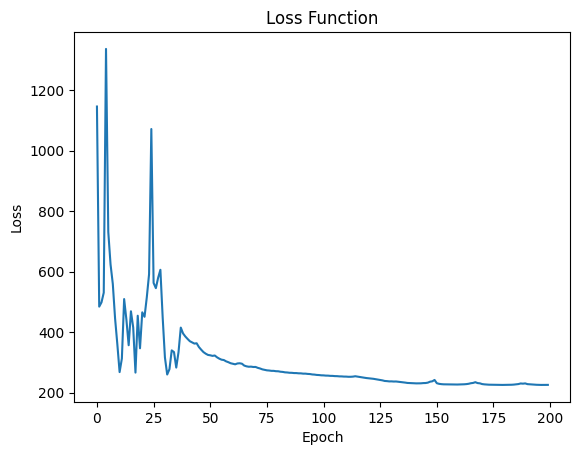

In [9]:
epoch = np.linspace(0, len(loss_list)-1, len(loss_list))
plt.plot(epoch, loss_list)
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Testing

In [10]:
context = ['A', 'D']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)
t = a[0] - torch.min(a[0])
tn = t.tolist()
tn = [float(i)/sum(tn) for i in tn]
pred = {}
for i in ix_to_word:
    pred.update({ix_to_word[i]:tn[i]})   
pred = dict(sorted(pred.items(), key=lambda item: item[1], reverse=True))
print('Training Traces: A-B-D-E-F, A-C-D-E-F, A-E-F')
print("Context: ", context)
print("Prediction: ", list(pred)[0])
for key, value in pred.items():
    print(key, " = ", round(value, 2))

Training Traces: A-B-D-E-F, A-C-D-E-F, A-E-F
Context:  ['A', 'D']
Prediction:  C
C  =  0.43
B  =  0.41
x  =  0.08
E  =  0.08
A  =  0.0
D  =  0.0
F  =  0.0


In [11]:
event=[]
likelihood = []

In [12]:
def predict(context):
    event=[]
    likelihood = []
    context_vector = make_context_vector(context, word_to_ix)
    a = model(context_vector)
    t = a[0] - torch.min(a[0])
    tn = t.tolist()
    tn = [float(i)/sum(tn) for i in tn]
    pred = {}
    for i in ix_to_word:
        pred.update({ix_to_word[i]:tn[i]})   
    pred = dict(sorted(pred.items(), key=lambda item: item[1], reverse=True))
    print(list(pred.items())[0])
    event.append(list(pred)[0])

predict(context)

('C', 0.4317309971731381)


In [13]:
for i in range(10):
    context = raw_text[i:i+3:2]
    predict(context)

('C', 0.4317309971731381)
('D', 0.5283036520903744)
('E', 0.5503149285558873)
('F', 0.448060251815282)
('x', 0.47786933787623215)
('A', 0.6685906189259399)
('C', 0.4317309971731381)
('D', 0.4834710700924633)
('E', 0.5503149285558873)
('F', 0.448060251815282)


In [14]:
event=[]
likelihood = []
def predict(event, likelihood):
    for i in range(0, len(raw_text)):
        context = raw_text[i:i+3:2]
        context_vector = make_context_vector(context, word_to_ix)
        a = model(context_vector)
        t = a[0] - torch.min(a[0])
        tn = t.tolist()
        tn = [float(i)/sum(tn) for i in tn]
        pred = {}
        for i in ix_to_word:
            pred.update({ix_to_word[i]:tn[i]})   
        pred = dict(sorted(pred.items(), key=lambda item: item[1], reverse=True))
        #print(list(pred.items())[0])
        event.append(list(pred)[0])
        likelihood.append(list(pred.items())[0][1])
    print(event)
    print(likelihood)

In [15]:
predict(event, likelihood)

['C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'F', 'x', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'F', 'x', 'F', 'x', 'F', 'x', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'F', 'x', 'F', 'x', 'F', 'x', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'A', 'C', 'D', 'E', 'F', 'x', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A', 'C', 'D', 'E', 'F', 'x', 'A',

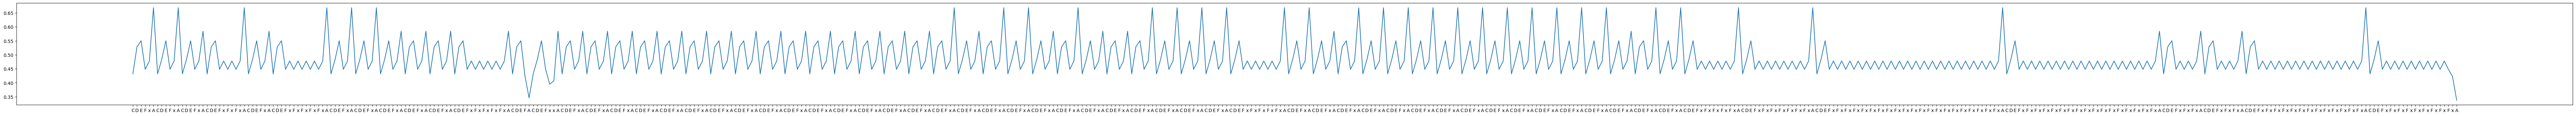

In [16]:
event_x = [i for i in range(len(event))]
plt.figure(figsize=(100, 4))
plt.plot(event_x, likelihood)
plt.xticks(event_x, event)
plt.show()

In [17]:
b1 = 1.2
b2 = 1.2
b3 = 1.3
k = 4
split = []
a = 0
for i in range(len(raw_text)):
    if likelihood[i] > likelihood[i-1]*b1:
        if likelihood[i] > likelihood[i+1]*b2:
            prev = 0
            for j in range(k):
                prev = prev + likelihood[i-1-k]
            if likelihood[i] > prev*b3/k:
                    #print(likelihood[i], prev/k)
                    b = i+1
                    split.append(raw_text[a:b])
                    a = i+1
                    print(event[i])

A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A
A


In [18]:
split

[['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x', 'A', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x', 'A', 'E', 'F', 'x', 'A', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'C', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A',
  'B',
  'D',
  'E',
  'F',
  'x',
  'A',
  'E',
  'F',
  'x',
  'A',
  'E',
  'F',
  'x',
  'A',
  'B',
  'D',
  'E',
  'F',
  'A',
  'C',
  'D',
  'E',
  'F',
  'x',
  'x',
  'A',
  'B',
  'D',
  'E',
  'F',
  'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 'F', 'x'],
 ['A', 'B', 'D', 'E', 

In [19]:
type(raw_text[0:10])

list